###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2016 I.Kursakov.  Partly based on content by L.A. Barba, G.F. Forsyth, I. Hawke, also under CC-BY.

# Бросаем бумажный самолетик 

На сегодняшнем занятии мы рассмотрим применение модели фугоидного движения к определнию оптимальных параметров запуска (а именно, начальную скорость и угол броска) бумажного самолетика. Аэродинамические характеристики и тримменрная скорость модели самолетика взяты из работы  Feng et al. 2009 _"On the aerodynamics of paper airplanes"_, AIAA paper 2009-3958, 27th AIAA Applied Aerodynamics Conference, San Antonio, TX. [PDF](http://arc.aiaa.org/doi/abs/10.2514/6.2009-3958).
Как обычно, начинаем с импорта необходимых модулей и настроек отображения графики.

In [1]:
from math import sin, cos, log, pi, degrees
import numpy
import matplotlib.pyplot as plt
from scipy import optimize
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

Движение самолетика описывается системой ОДУ, которая в векторном виде выглядит весьма незамысловато:

$$u'(t) = f(u),$$

где

\begin{align}
u & = \begin{pmatrix} v \\ \theta \\ x \\ y \end{pmatrix} & f(u) & = \begin{pmatrix} - g\, \sin\theta - \frac{C_D}{C_L} \frac{g}{v_t^2} v^2 \\ - \frac{g}{v}\,\cos\theta + \frac{g}{v_t^2}\, v \\ v\cos\theta \\ v\sin\theta \end{pmatrix}.
\end{align}

Эту систему мы решаем методом Эйлера. Для удобства рализации этой процедуры на прошлом занятии мы написали две функции — правую часть и, собственно, шаг метода Эйлера.

In [2]:
def f(u):
    """Returns the right-hand side of the phugoid system of equations.
    
    Parameters
    ----------
    u : array of float
        array containing the solution at time n.
        
    Returns
    -------
    dudt : array of float
        array containing the RHS given u.
    """
    
    v = u[0]
    theta = u[1]
    x = u[2]
    y = u[3]
    return numpy.array([-g*sin(theta) - C_D/C_L*g/v_t**2*v**2,
                      -g*cos(theta)/v + g/v_t**2*v,
                      v*cos(theta),
                      v*sin(theta)])

In [3]:
def euler_step(u, f, dt):
    """Returns the solution at the next time-step using Euler's method.
    
    Parameters
    ----------
    u : array of float
        solution at the previous time-step.
    f : function
        function to compute the right hand-side of the system of equation.
    dt : float
        time-increment.
    
    Returns
    -------
    u_n_plus_1 : array of float
        approximate solution at the next time step.
    """
    
    return u + dt * f(u)

Нами было показано, что реализованный метод имеет первый порядок. Повысить порядок схемы можно, если добавить процедуру "предиктор-корректор". Получившаяся схема носит название "метод Эйлера с центральной точкой" или "метод Эйлера с пересчетом".

In [4]:
def euler_midpoint_step(u, f, dt):
    """Returns the solution at the next time-step using Euler's method with 
    middle point.
    
    Parameters
    ----------
    u : array of float
        solution at the previous time-step.
    f : function
        function to compute the right hand-side of the system of equation.
    dt : float
        time-increment.
    
    Returns
    -------
    u_n_plus_1 : array of float
        approximate solution at the next time step.
    """
    u_star = u + 0.5*dt * f(u)
    return u + dt * f(u_star)

Сам процесс шагания по времени также можно оформить в виде функции — это может пригодиться, если, например, нужно будет перебирать начальные условия в цикле. В функции `time_loop ()` я использую цикл `while`, условием выхода из цикла является проверка высоты полета самолетика. Еще стоит обратить внимание, что массив решений `u` заполняется по ходу цикла, для чего используется метод `numpy.append`. Функция возвращает пару — вектор решения и время полета самолетика до падения.

In [5]:
def time_loop(u0,dt):
    """Returns the array of u vectors at each time step
    
    Parameters
    ----------
    u0 : array of float
         initial conditions
    dt : float
         time step
         
    Returns
    -------
    u : array of u arrays with shape (n,4), n - number of time steps while y >0
    T : float
        final time
    """
    
    u = numpy.zeros((1, 4))
    u[0] = numpy.copy(u0) # fill 1st element with initial values
    # time loop - Euler method
    T = 0                               # final time
    
    y=u0[3]
    n=0
    while y >0:
    
#        u = numpy.resize(u,(n+2,4))
#        u[n+1] = euler_step(u[n], f, dt)
        u = numpy.append(u,[euler_midpoint_step(u[n], f, dt)],axis = 0)
        y = u[n+1,3]
        n=n+1
        T+=dt
    
    return u,T

Метод numpy.append довольно медленный, если нужно определять дистанцию много раз, при этом подробности полета не важны, можно не хранить всю историю решения, а переписывать текущие значения на каждом шаге.

In [6]:
def time_loop_for_cycle(u0,dt):
    """Returns the u vector at final time step
    
    Parameters
    ----------
    u0 : array of float
         initial conditions
    dt : float
         time step
         
    Returns
    -------
    u : array of float
    T : float
        final time
    """
    u = numpy.copy(u0) # fill 1st element with initial values
    # time loop - Euler method
    T = 0                               # final time
    
    y=u0[3]
    n=0
    while y >0:
    
        u = euler_midpoint_step(u, f, dt)
#        u = numpy.append(u,[euler_step(u[n], f, dt)],axis = 0)
        y = u[3]
        n=n+1
        T+=dt
    
    return u,T

Собственно, функция, для определения дистанции полета.

In [7]:
def distance(v0_theta0, *params):
    """Returns the distance that paperplane flies before hitting the ground
    when launched at given theta_0
    
    Parameters
    ----------
    u0 : array of float
         initial conditions
    
    Returns
    -------
    l : float
        final distance
    """
    v0,theta0 = v0_theta0
    x0,y0,dt = params
    
    u,T = time_loop_for_cycle(numpy.array([v0, theta0, x0, y0]),dt)

    return u[2]

И еще пара вспомогательных: 

In [8]:
def inv_distance(v0_theta0, *params):
    v0,theta0 = v0_theta0
    x0,y0,dt = params
    return 1./distance(v0_theta0, *params)    
def neg_distance(v0_theta0, *params):
    v0,theta0 = v0_theta0
    x0,y0,dt = params
    return -distance(v0_theta0, *params)    

Раз мы ищем _оптимальные_ значения, имеет смысл воспользоваться специальным инструментарием для поиска оптимума. Например, мнтодом  `optimize.brute()` из пакета SciPy. Как следует из названия, в нем реализован прямой перебор вариантов. Кроме этого, полученное значение можно затем использовать для какого-нибудь алгоритма оптимизации в качестве первого приближения. За это отвечает опция `finish= `. Мы используем этод метод с опцией `finish= optimize.fmin`, что соответствует методу Нелдера-Мида.

In [9]:
#%%prun
dt = 0.001
# model parameters for paperplane:
g = 9.8      # gravity in m s^{-2}
v_t = 4.9   # trim velocity in m s^{-1}   
C_D = 1/5.  # drag coefficient --- or D/L if C_L=1
C_L = 1.0    # for convenience, use C_L = 1

### set initial conditions ###

x0 = 0.0  # horizotal position is arbitrary
y0 = 2  # initial altitude

v0_max = 12.5 #maximum initial velocity
thetha0_max = pi/3 #maximal initial angle

dv0 = 0.5 #velocity step
dt0 = 0.035 #angle step in radians



rranges = (slice(0.5,v0_max,dv0),slice(-0.5,thetha0_max,dt0))
resbrute = optimize.brute(neg_distance, rranges, args=(x0,y0,dt), full_output=True,
                          finish=optimize.fmin)


max_dist =  - resbrute[1]    

v0, theta0  = resbrute[0]
vv,tt = resbrute[2]
vv0_values =  vv[:,0]
tt0_values = tt[0,:]

 
print ("Maximum distance is %.2f. \
Initial values: v0 = %.2f, t0 = %.2f" % (max_dist,v0,theta0))


Maximum distance is 18.06. Initial values: v0 = 10.04, t0 = -0.32


Теперь, когда у нас есть оптимальные значения, можно посчитать всю траекторию для таких параметров запуска и визуализировать результат.

In [10]:
u,T = time_loop(numpy.array([v0, theta0, x0, y0]),dt)
 # get the glider's position with respect to the time
x = u[:,2]
y = u[:,3]
v = u[:,0]

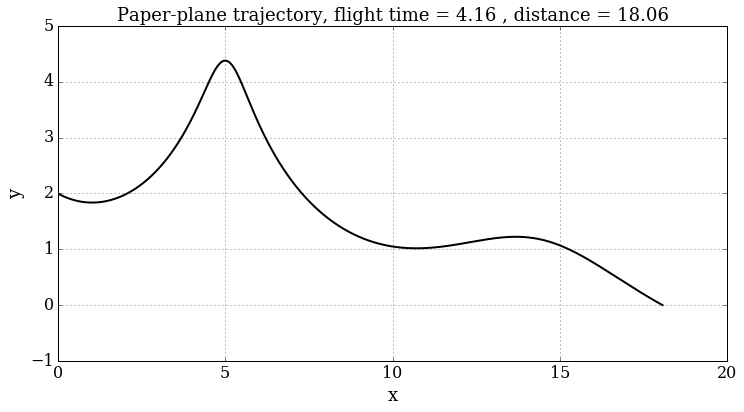

In [15]:
 # visualization of the path
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel(r'x', fontsize=18)
plt.ylabel(r'y', fontsize=18)
plt.title('Paper-plane trajectory, flight time = %.2f , distance = %.2f' % (T,max(x)), fontsize=18)
plt.plot(x,y, 'k-', lw=2);
 


В результате работы метода `optimize.brute()` мы получили массив решений при различных значениях начальных параметров. Эти данные тоже можно визуализировать при помощи методов `contour` и `pcolor` библиотеки Matplotlib.

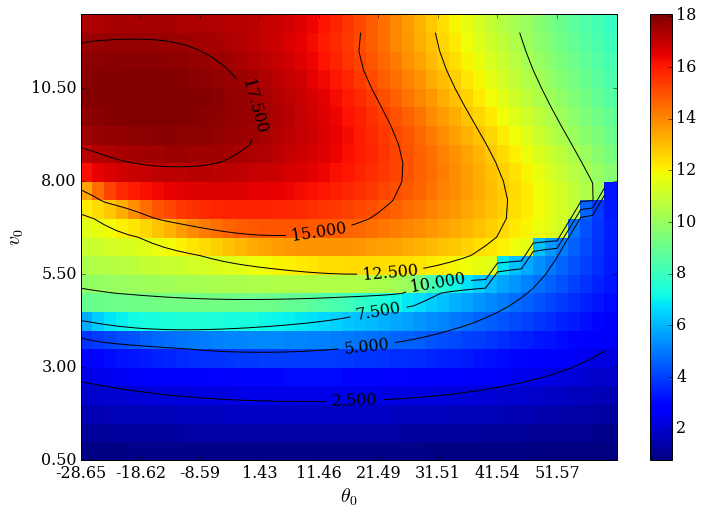

In [16]:
plt.figure(figsize=(12,8))
plt.pcolor(-resbrute[-1])
plt.colorbar()
CS=plt.contour(-resbrute[-1],colors ='k')
plt.clabel(CS,inline =1,fontsize = 16)
plt.ylabel(r'$v_0$', fontsize=20)
ylocs,ylabels = plt.yticks()
plt.yticks(ylocs[:-1],tuple('%.2f' % vv0_values[int(i)] for i in ylocs[:-1]))
plt.xlabel(r'$\theta_0$', fontsize=20)
xlocs,xlabels = plt.xticks()
plt.xticks(xlocs[:-1],tuple('%.2f' % degrees(tt0_values[int(i)]) for i in xlocs[:-1]))
#plt.suptitle('Maximum distance (in m) for different initial conditions.', fontsize=18)
plt.show()

---

###### The cell below loads the style of the notebook.

In [17]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())

FileNotFoundError: [Errno 2] No such file or directory: '../../styles/numericalmoocstyle.css'